# ccdproc-02:   Trimming

## Overview
1. Build a list of all image files
2. How to trim images 
3. Trim all the images to the selected region of interest

<pre>
Máster en Astrofísica UCM  -- Técnicas Experimentales en Astrofísica  
Jaime Zamorano and Nicolás Cardiel

This notebook has reproduced parts of the the astropy ccdproc docs: 
https://ccdproc.readthedocs.io/en/latest/reduction_toolbox.html#subtract-overscan-and-trim-images

Version 1.0 2021/01/14  
</pre>

Note that the ``astropy`` package should be installed. In this sense, have a look to the
astropy installation description: https://docs.astropy.org/en/stable/install.html.

In [1]:
from pathlib import Path
from astropy.io import fits
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.style.use('./tea.mplstyle')

### Working with images in a directory
We will use the files of the first night of observations at NOT (Nordic Optical Telescope) 2008 that can be downloaded from   ftp://astrax.fis.ucm.es/pub/users/jaz/NOT_2008_04_12-14/N1/
or 
http://guaix.fis.ucm.es/~jaz/master_TEA/observaciones_NOT_2008/N1/

``directory`` should point to the directory with the downloaded images

In [3]:
dirname = 'N1'
directory = Path(dirname)

In [4]:
%%bash
# Version complicada, solo descarga si es necesario
TARBALL=NOT_20080412_N1.tar.gz
DIR=N1
URI=ftp://astrax.fis.ucm.es/pub/users/jaz/NOT_2008_04_12-14/"$TARBALL"
if [ ! -f "$TARBALL" ]; then
    echo "$TARBALL does not exist, download"
    curl -C -  -O "$URI"
fi
if  [ ! -d "$DIR" ]; then
    mkdir -p $DIR
    tar -x -f NOT_20080412_N1.tar.gz -a --strip-components=1 -C $DIR
fi

Let\'s create a list containing all the FITS files in that directory 

In [5]:
filelist = list(sorted(directory.glob('AL*.fits')))
print(filelist[10:20])    # printing only from 10 to 20

[PosixPath('N1/AL12011.fits'), PosixPath('N1/AL12012.fits'), PosixPath('N1/AL12013.fits'), PosixPath('N1/AL12014.fits'), PosixPath('N1/AL12015.fits'), PosixPath('N1/AL12016.fits'), PosixPath('N1/AL12017.fits'), PosixPath('N1/AL12018.fits'), PosixPath('N1/AL12019.fits'), PosixPath('N1/AL12020.fits')]


Let\'s open one of the files to explore the HEADER keywords

In [6]:
HDUList_object = fits.open(filelist[101])
HDUList_object.info()

Filename: N1/AL12102.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (2198, 2052)   int16 (rescales to uint16)   


In [7]:
# Extract primary header
primary_header = HDUList_object[0].header
# Index header object with keyword name and print value
print('filename:',primary_header['FILENAME'],'    Object:',primary_header['OBJECT'])
# Read the data to a numpy array
image = fits.getdata(filelist[101])
print(type(image))
print('dimension:',image.shape)
naxis2, naxis1 = image.shape
print('naxis1:',image.shape[1])
print('naxis2:',image.shape[0])

filename: ALrd120102.fits     Object: GC4496A R 3x300s
<class 'numpy.ndarray'>
dimension: (2052, 2198)
naxis1: 2198
naxis2: 2052


Let\'s display this file

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


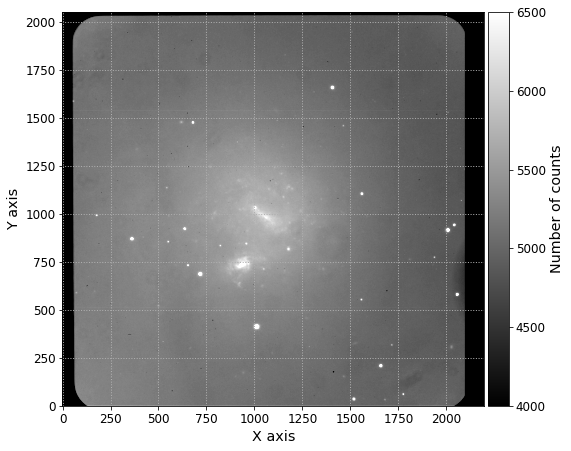

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
img = ax.imshow(image, vmin=4000, vmax=6500)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax, label='Number of counts')
ax.grid()

Selecting a region of the image can be done using ``trimming`` or simply using the python command.

### Trimming using python 

In [11]:
new_image = image[0:1000,0:1250]

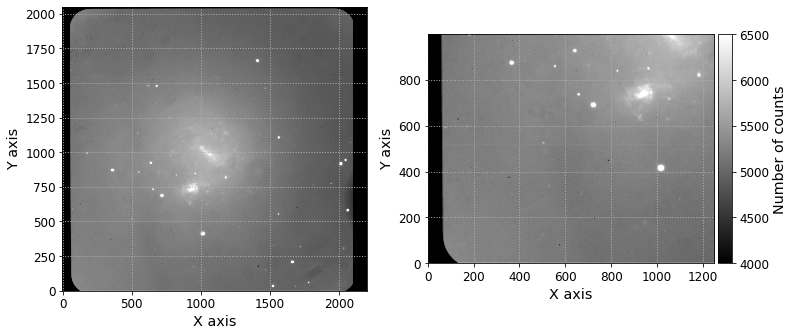

In [12]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
ax0 = axarr[0]
img = ax0.imshow(image, vmin=4000, vmax=6500)
ax0.set_xlabel('X axis')
ax0.set_ylabel('Y axis')
ax0.grid()
ax1 = axarr[1]
img = ax1.imshow(new_image, vmin=4000, vmax=6500)
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax, label='Number of counts')
ax1.grid()

In [13]:
### Trimming using python the region of interest TRIMSEC= [20:-20,60:2100]
new_image = image[20:-20,60:2100]
print(image.shape,new_image.shape)

(2052, 2198) (2012, 2040)


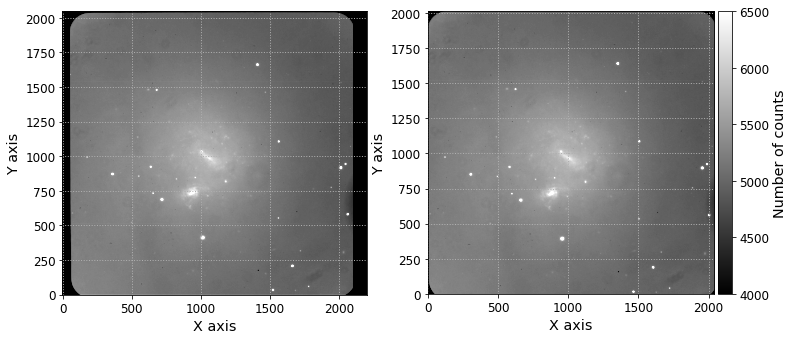

In [14]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
ax0 = axarr[0]
img = ax0.imshow(image, vmin=4000, vmax=6500)
ax0.set_xlabel('X axis')
ax0.set_ylabel('Y axis')
ax0.grid()
ax1 = axarr[1]
img = ax1.imshow(new_image, vmin=4000, vmax=6500)
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax, label='Number of counts')
ax1.grid()

### Trimming with ccdproc trim_image
We need to convert the numpy array to [CCDData](https://docs.astropy.org/en/stable/api/astropy.nddata.CCDData.html) class

In [13]:
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc

In [14]:
data_image = CCDData(image, unit=u.adu)

In [15]:
# FITS-style
t_image_1 = ccdproc.trim_image(data_image, fits_section='[60:2099, 21:2032]')
# python-style:
t_image_2 = ccdproc.trim_image(data_image[20:-20,60:2100])
print(t_image_1.shape, t_image_2.shape)

(2012, 2040) (2012, 2040)


In [16]:
t_image_1.meta

OrderedDict([('trim_image', ('trimim', 'Shortened name for ccdproc command')),
             ('trimim', 'ccd=<CCDData>, fits_section=[60:2099, 21:2032]')])

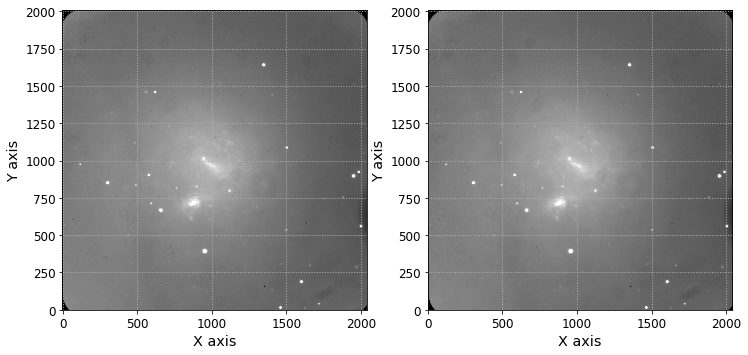

In [17]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
ax0 = axarr[0]
img = ax0.imshow(t_image_1, vmin=4000, vmax=6500)
ax0.set_xlabel('X axis')
ax0.set_ylabel('Y axis')
ax0.grid()
ax1 = axarr[1]
img = ax1.imshow(t_image_2, vmin=4000, vmax=6500)
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.grid()

### Writing the resulting image as FITS file

We can write the resulting CCDdata file to a FITS file.  
The trim_image command maintain the information of the header (metadata) and also add some information. We will add more information.

In [18]:
# Replace FILENAME keyword and add information
t_image_1.header['FILENAME']  = 't_ALrd120102.fits' 
nowtime = datetime.datetime.now().isoformat('T', timespec='seconds')
t_image_1.header['HISTORY'] = f'{nowtime} astropy ccdproc trim_image'

In [19]:
t_image_1.write('dummy.fits',overwrite='yes')

In [10]:
# We are done, close the file
HDUList_object.close()

## Trimming all the images of the first night

We are using this method to trim all the images of the first night of the NOT2008 campaing.  
We will read all the files to create CCDData objects. We created earlier in this notebook the list of files as filelist.

In [20]:
for filename in filelist:
    image = CCDData.read(filename, unit="adu")
    t_image = ccdproc.trim_image(image[20:-20,60:2100])
    name_of_file = 't_{}'.format(image.header['FILENAME'])
    t_image.header['FILENAME']  = name_of_file
    nowtime = datetime.datetime.now().isoformat('T', timespec='seconds')
    t_image.header['HISTORY'] = f'{nowtime} astropy ccdproc trim_image'
    t_image.header['HISTORY']  = 'trimming fits_section=[60:2099, 21:2032]' 
    print(f'writting {name_of_file} in {directory}')
    t_image.write(directory / name_of_file, overwrite='yes')

INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120001.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120002.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120003.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120004.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120005.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120006.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120007.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120008.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120009.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120010.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120011.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120012.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120013.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120014.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120015.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120016.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120017.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120018.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120019.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120020.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120021.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120022.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120023.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120024.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120025.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120026.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120027.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120028.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120029.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120030.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120031.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120032.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120033.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120034.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120035.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120036.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120037.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120038.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120039.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120040.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120041.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120042.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120043.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120044.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120045.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120046.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120047.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120048.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120049.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120050.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120051.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120052.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120053.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120054.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120055.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120056.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120057.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120058.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120059.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120060.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
WARNING

writting t_ALrd120061.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120062.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120063.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120064.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120065.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -17.885083 from OBSGEO-[XYZ].
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120066.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120067.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120068.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120069.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120070.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120071.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120072.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120073.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120074.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120075.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120076.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120077.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120078.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120079.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120080.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120081.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120082.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120083.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120084.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120085.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120086.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120087.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120088.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120089.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120090.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120091.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120092.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120093.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120094.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120095.fits in N1
INFO: using the unit adu passed to the FITS reade

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120099.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120100.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120101.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120102.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120103.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120104.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120105.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120106.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120107.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120108.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120109.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120110.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120111.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120112.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120113.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120114.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120115.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120116.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120117.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120118.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120119.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120120.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120121.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120122.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120123.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120124.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120125.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120126.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120127.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120128.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120129.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120130.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120131.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120132.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120133.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120134.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120135.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120136.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120137.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


writting t_ALrd120138.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120139.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120140.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120141.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120142.fits in N1


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120143.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120144.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120145.fits in N1
INFO: using the unit adu passed to the FITS reader instead of the unit count in the FITS file. [astropy.nddata.ccddata]
writting t_ALrd120146.fits in N1
